Solution Status: Optimal
Objective (makespan) = 23.0
Start time of Job 0 on Machine 0 = 0.0
Start time of Job 1 on Machine 0 = 11.0
Start time of Job 2 on Machine 0 = 7.0
Start time of Job 0 on Machine 1 = 7.0
Start time of Job 1 on Machine 1 = 0.0
Start time of Job 2 on Machine 1 = 16.0
Start time of Job 0 on Machine 2 = 16.0
Start time of Job 1 on Machine 2 = 2.0
Start time of Job 2 on Machine 2 = 11.0


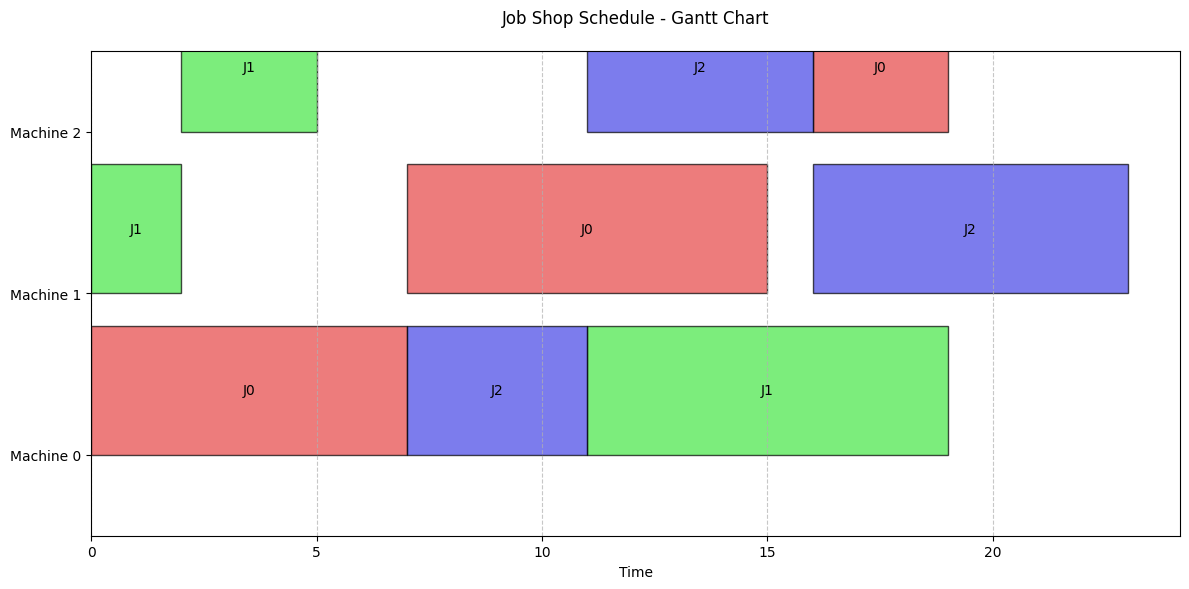

In [ ]:
#!pip install pulp

import pulp

# -------------------------
# 1) PROBLEM PARAMETERS
# -------------------------
num_jobs = 3
num_machines = 3

# machine_order[job] = list of machines in the order they must be processed
# Example: Job 0 -> Machine 0 -> Machine 1 -> Machine 2
machine_order = [
    [0, 1, 2],  # Job 0
    [1, 2, 0],  # Job 1
    [0, 2, 1]   # Job 2
]

# processing_time[job] = list of processing times for each operation in the sequence
# For Job 0: 5 hours on Machine 0, 6 hours on Machine 1, 4 hours on Machine 2
processing_time = [
    [7, 8, 3],  # Job 0
    [2, 3, 8],  # Job 1
    [4, 5, 7]   # Job 2
]

# -------------------------
# 2) DECISION VARIABLES
# -------------------------
# We'll create a variable start_time[m, j] = the start time of Job j on Machine m.
# Because each job visits each machine exactly once (in a known order), we can define variables for each (m, j).
# Alternatively, we might define them only in operation order; for simplicity, we'll define them for (m, j).
start_time = pulp.LpVariable.dicts(
    "start_time",
    [(m, j) for m in range(num_machines) for j in range(num_jobs)],
    lowBound=0,
    cat='Continuous'
)

# We'll create a variable Cmax to represent the makespan (the maximum finishing time).
Cmax = pulp.LpVariable('Cmax', lowBound=0, cat='Continuous')

# -------------------------
# 3) MODEL
# -------------------------
model = pulp.LpProblem("Job_Shop_Scheduling", pulp.LpMinimize)

# Objective: Minimize the makespan
model += Cmax, "Minimize_makespan"

# -------------------------
# 4) CONSTRAINTS
# -------------------------

# (A) **Operation sequence** constraints:
#     For each job j, each operation must start after the previous one finishes.

for j in range(num_jobs):
    for op in range(num_machines - 1):
        current_machine = machine_order[j][op]
        next_machine = machine_order[j][op + 1]

        current_op_time = processing_time[j][op]

        # The start of the next operation must be >= (start of current operation + processing time).
        model += start_time[next_machine, j] >= (
            start_time[current_machine, j] + current_op_time
        ), f"SequenceConstraint_Job{j}_Op{op}"

# (B) **No overlap on the same machine**:
#     If two jobs j1 and j2 require the same machine m, only one can run at a time.
#     We'll use the "big-M" approach with binary variables to enforce non-overlapping intervals.

# Big M can be a large enough number. For a small example, let's pick something > sum of all times.
bigM = 9999

# Create binary variables that indicate ordering between job pairs on each machine.
# y[m, j1, j2] = 1 means job j1 finishes before job j2 starts (on machine m).
y = pulp.LpVariable.dicts(
    "y",
    [(m, j1, j2) for m in range(num_machines) for j1 in range(num_jobs) for j2 in range(num_jobs) if j1 != j2],
    cat='Binary'
)

for m in range(num_machines):
    # Retrieve jobs that run on machine m, but we actually know each job runs on m exactly once in some order
    # We just loop over all pairs j1, j2.
    for j1 in range(num_jobs):
        for j2 in range(num_jobs):
            if j1 != j2:
                # processing time of job j1 on machine m
                # We need to figure out which operation index job j1 uses machine m
                op_j1 = machine_order[j1].index(m)  # index of machine m in job j1's sequence
                proc_j1 = processing_time[j1][op_j1]

                op_j2 = machine_order[j2].index(m)
                proc_j2 = processing_time[j2][op_j2]

                # Non-overlap constraints:
                # start_time[m, j2] >= start_time[m, j1] + proc_j1 - bigM*(1 - y[m, j1, j2])
                model += start_time[m, j2] >= start_time[m, j1] + proc_j1 - bigM * (1 - y[m, j1, j2])

                # Similarly:
                # start_time[m, j1] >= start_time[m, j2] + proc_j2 - bigM*(y[m, j1, j2])
                model += start_time[m, j1] >= start_time[m, j2] + proc_j2 - bigM * (y[m, j1, j2])

# (C) **Makespan definition**:
#     For each job j, the finishing time on its last machine must be <= Cmax.
for j in range(num_jobs):
    # last machine index for job j (the job visits machines in a known order)
    last_machine = machine_order[j][-1]
    # last operation index (which is num_machines - 1)
    last_op_idx = num_machines - 1
    finish_time_j = start_time[last_machine, j] + processing_time[j][last_op_idx]

    model += Cmax >= finish_time_j, f"CmaxConstraint_Job{j}"

# -------------------------
# 5) SOLVE
# -------------------------
model.solve(pulp.PULP_CBC_CMD(msg=False))

print("Solution Status:", pulp.LpStatus[model.status])
print("Objective (makespan) =", pulp.value(model.objective))

# Print the start times
for (m, j) in start_time:
    print(f"Start time of Job {j} on Machine {m} = {pulp.value(start_time[m, j])}")
# Create Gantt chart
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import colorsys

# Set up the plot with dynamic sizing based on number of machines
fig_height = max(6, num_machines * 0.5)  # Increase height for many machines
fig, ax = plt.subplots(figsize=(12, fig_height))

# Generate colors dynamically based on number of jobs
def generate_colors(n):
    colors = []
    for i in range(n):
        hue = i / n
        saturation = 0.7
        value = 0.9
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        colors.append(rgb)
    return colors

colors = generate_colors(num_jobs)

# For each machine and job
for m in range(num_machines):
    for j in range(num_jobs):
        # Get start time and processing time
        start = pulp.value(start_time[m, j])
        op_idx = machine_order[j].index(m)
        duration = processing_time[j][op_idx]

        # Calculate rectangle height based on number of machines
        rect_height = min(0.8, 0.95 - (0.01 * num_machines))

        # Create rectangle for this operation
        rect = patches.Rectangle(
            (start, m),                     # (x,y)
            duration,                       # width
            rect_height,                    # height
            facecolor=colors[j],
            edgecolor='black',
            alpha=0.7
        )

        # Add rectangle to plot
        ax.add_patch(rect)

        # Adjust text size based on number of jobs and machines
        text_size = max(8, min(10, 200/(num_jobs * num_machines)))

        # Add job number text in the middle of rectangle
        ax.text(start + duration/2, m + rect_height/2, f'J{j}',
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=text_size)

# Customize the plot
ax.set_ylim(-0.5, num_machines - 0.5)
ax.set_xlim(0, pulp.value(Cmax) * 1.05)  # Add 5% margin

# Adjust tick label size based on number of machines
tick_size = max(8, min(10, 120/num_machines))
ax.set_yticks(range(num_machines))
ax.set_yticklabels([f'Machine {m}' for m in range(num_machines)], fontsize=tick_size)
ax.set_xlabel('Time', fontsize=tick_size)
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

plt.title('Job Shop Schedule - Gantt Chart', pad=20, fontsize=tick_size + 2)
plt.tight_layout()
plt.show()


Solution Status: Optimal
Objective (makespan) = 23.0
Start time of Job 0 on Machine 0 = 0.0
Start time of Job 1 on Machine 0 = 11.0
Start time of Job 2 on Machine 0 = 7.0
Start time of Job 0 on Machine 1 = 7.0
Start time of Job 1 on Machine 1 = 0.0
Start time of Job 2 on Machine 1 = 16.0
Start time of Job 0 on Machine 2 = 16.0
Start time of Job 1 on Machine 2 = 2.0
Start time of Job 2 on Machine 2 = 11.0


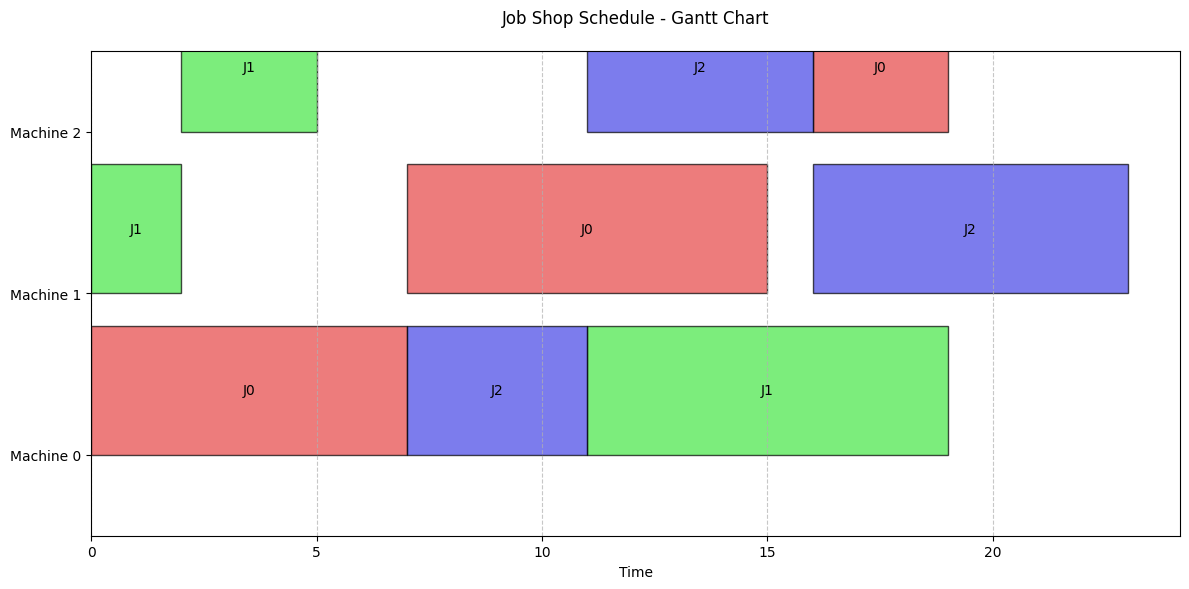

In [ ]:
#!pip install pulp

import pulp

num_jobs = 3
num_machines = 3

machine_order = [
    [0, 1, 2],  # Job 0
    [1, 2, 0],  # Job 1
    [0, 2, 1]   # Job 2
]

processing_time = [
    [7, 8, 3],  # Job 0
    [2, 3, 8],  # Job 1
    [4, 5, 7]   # Job 2
]

start_time = pulp.LpVariable.dicts(
    "start_time",
    [(m, j) for m in range(num_machines) for j in range(num_jobs)],
    lowBound=0,
    cat='Continuous'
)

Cmax = pulp.LpVariable('Cmax', lowBound=0, cat='Continuous')

model = pulp.LpProblem("Job_Shop_Scheduling", pulp.LpMinimize)

model += Cmax, "Minimize_makespan"

for j in range(num_jobs):
    for op in range(num_machines - 1):
        current_machine = machine_order[j][op]
        next_machine = machine_order[j][op + 1]
        current_op_time = processing_time[j][op]
        model += start_time[next_machine, j] >= (
            start_time[current_machine, j] + current_op_time
        ), f"SequenceConstraint_Job{j}_Op{op}"

bigM = 9999

y = pulp.LpVariable.dicts(
    "y",
    [(m, j1, j2) for m in range(num_machines) for j1 in range(num_jobs) for j2 in range(num_jobs) if j1 != j2],
    cat='Binary'
)

for m in range(num_machines):
    for j1 in range(num_jobs):
        for j2 in range(num_jobs):
            if j1 != j2:
                op_j1 = machine_order[j1].index(m)
                proc_j1 = processing_time[j1][op_j1]
                op_j2 = machine_order[j2].index(m)
                proc_j2 = processing_time[j2][op_j2]
                model += start_time[m, j2] >= start_time[m, j1] + proc_j1 - bigM * (1 - y[m, j1, j2])
                model += start_time[m, j1] >= start_time[m, j2] + proc_j2 - bigM * (y[m, j1, j2])

for j in range(num_jobs):
    last_machine = machine_order[j][-1]
    last_op_idx = num_machines - 1
    finish_time_j = start_time[last_machine, j] + processing_time[j][last_op_idx]
    model += Cmax >= finish_time_j, f"CmaxConstraint_Job{j}"

model.solve(pulp.PULP_CBC_CMD(msg=False))

print("Solution Status:", pulp.LpStatus[model.status])
print("Objective (makespan) =", pulp.value(model.objective))

for (m, j) in start_time:
    print(f"Start time of Job {j} on Machine {m} = {pulp.value(start_time[m, j])}")

# Create Gantt chart
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import colorsys

# Set up the plot with dynamic sizing based on number of machines
fig_height = max(6, num_machines * 0.5)  # Increase height for many machines
fig, ax = plt.subplots(figsize=(12, fig_height))

# Generate colors dynamically based on number of jobs
def generate_colors(n):
    colors = []
    for i in range(n):
        hue = i / n
        saturation = 0.7
        value = 0.9
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        colors.append(rgb)
    return colors

colors = generate_colors(num_jobs)

# For each machine and job
for m in range(num_machines):
    for j in range(num_jobs):
        # Get start time and processing time
        start = pulp.value(start_time[m, j])
        op_idx = machine_order[j].index(m)
        duration = processing_time[j][op_idx]

        # Calculate rectangle height based on number of machines
        rect_height = min(0.8, 0.95 - (0.01 * num_machines))

        # Create rectangle for this operation
        rect = patches.Rectangle(
            (start, m),                     # (x,y)
            duration,                       # width
            rect_height,                    # height
            facecolor=colors[j],
            edgecolor='black',
            alpha=0.7
        )

        # Add rectangle to plot
        ax.add_patch(rect)

        # Adjust text size based on number of jobs and machines
        text_size = max(8, min(10, 200/(num_jobs * num_machines)))

        # Add job number text in the middle of rectangle
        ax.text(start + duration/2, m + rect_height/2, f'J{j}',
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=text_size)

# Customize the plot
ax.set_ylim(-0.5, num_machines - 0.5)
ax.set_xlim(0, pulp.value(Cmax) * 1.05)  # Add 5% margin

# Adjust tick label size based on number of machines
tick_size = max(8, min(10, 120/num_machines))
ax.set_yticks(range(num_machines))
ax.set_yticklabels([f'Machine {m}' for m in range(num_machines)], fontsize=tick_size)
ax.set_xlabel('Time', fontsize=tick_size)
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

plt.title('Job Shop Schedule - Gantt Chart', pad=20, fontsize=tick_size + 2)
plt.tight_layout()
plt.show()


# Production scheduling -- the job shop problem

## Problem Description
- We have a number of jobs: Job 0, Job 1, Job 2, ...
- We have a number of machines: Machine 0, Machine 1, Machine 2, ...
- Each job must be processed on each machine in a specific order.
- for example: Job 0 must be processed on Machine 0, then on Machine 1, then on Machine 2.
- No machine can process more than one job at a time.
- We assume unlimited buffers between machines, so jobs can immediately move to the next machine if it's available.
- **Objective**: Minimize the total completion time (makespan), C_max.

the effect of the job shop problem is a schedule, frequentely presented as a Gantt chart.

# ![Job shop problem example](https://www.researchgate.net/publication/370490241/figure/fig1/AS:11431281155279843@1683131798236/Job-sequence-on-machines-for-a-job-shop-problem-with-3-machines-and-2-jobs.png)

The problem is NP-hard, the more jobs and machines, the harder it is to solve.



## Mini Problem Example

### Scenario Setup
- **Machines**: 0 and 1
- **Jobs**: 0 and 1
- Each job has two operations, one on each machine, but in different orders

### Job 0
- **Operation 1**: Machine 0 → Processing time = 5
- **Operation 2**: Machine 1 → Processing time = 6
- Thus, Job 0 must go first to Machine 0, then to Machine 1

### Job 1
- **Operation 1**: Machine 1 → Processing time = 4  
- **Operation 2**: Machine 0 → Processing time = 7
- Thus, Job 1 must go first to Machine 1, then to Machine 0

### Objective
Minimize the makespan (C_max)

In [ ]:
!pip install pulp

import pulp

# 1) Create the problem
model = pulp.LpProblem("Small_Job_Shop", pulp.LpMinimize)

# 2) Decision variables
# Start times:
# s0_0: Start time of Job 0 on Machine 0
# s0_1: Start time of Job 0 on Machine 1
# s1_0: Start time of Job 1 on Machine 0
# s1_1: Start time of Job 1 on Machine 1
s0_0 = pulp.LpVariable("s0_0", lowBound=0, cat='Continuous')
s0_1 = pulp.LpVariable("s0_1", lowBound=0, cat='Continuous')
s1_0 = pulp.LpVariable("s1_0", lowBound=0, cat='Continuous')
s1_1 = pulp.LpVariable("s1_1", lowBound=0, cat='Continuous')

# Makespan
Cmax = pulp.LpVariable("Cmax", lowBound=0, cat='Continuous')

# 3) Processing times
# Job 0: M0=5, then M1=6
p0_m0 = 5 # processing time of Job 0 on Machine 0
p0_m1 = 6 # processing time of Job 0 on Machine 1

# Job 1: M1=4, then M0=7
p1_m1 = 4 # processing time of Job 1 on Machine 1
p1_m0 = 7 # processing time of Job 1 on Machine 0

# 4) Binary variables for machine usage ordering
# We need these to ensure no overlap on each machine - each machine can process only one job at a time.
# For Machine 0, let y0_01 = 1 if Job 0 finishes before Job 1 starts on M0, else 0.
# For Machine 1, let y1_01 = 1 if Job 0 finishes before Job 1 starts on M1, else 0.
y0_01 = pulp.LpVariable("y0_01", cat='Binary')  # ordering on Machine 0
y1_01 = pulp.LpVariable("y1_01", cat='Binary')  # ordering on Machine 1

# Define a "big M" large enough to cover maximum possible scheduling time
bigM = 9999

# 5) OBJECTIVE: minimize Cmax
model += Cmax, "Minimize_the_makespan"

# 6) CONSTRAINTS

# -- (A) Operation sequence for each job --

# Job 0 must finish on Machine 0 before starting on Machine 1:
model += s0_1 >= s0_0 + p0_m0, "Seq_Job0" # start time of Job 0 on Machine 1 must be greater than or equal to the start time of Job 0 on Machine 0 plus the processing time of Job 0 on Machine 0

# Job 1 must finish on Machine 1 before starting on Machine 0:
model += s1_0 >= s1_1 + p1_m1, "Seq_Job1" # start time of Job 1 on Machine 0 must be greater than or equal to the start time of Job 1 on Machine 1 plus the processing time of Job 1 on Machine 1

# -- (B) No overlap on Machine 0 --
# Machine 0 is used by:
#   - Job 0 (from s0_0 to s0_0 + p0_m0)
#   - Job 1 (from s1_0 to s1_0 + p1_m0)
# Use a big-M approach with binary y0_01:

# If y0_01 = 1, Job0 finishes before Job1 starts on M0:
#     s1_0 >= s0_0 + p0_m0 - bigM*(1 - y0_01)
model += s1_0 >= s0_0 + p0_m0 - bigM*(1 - y0_01), "NoOverlap0a"

# If y0_01 = 0, Job1 finishes before Job0 starts on M0:
#     s0_0 >= s1_0 + p1_m0 - bigM*(y0_01)
model += s0_0 >= s1_0 + p1_m0 - bigM*(y0_01), "NoOverlap0b"

# -- (C) No overlap on Machine 1 --
# Machine 1 is used by:
#   - Job 0 (from s0_1 to s0_1 + p0_m1)
#   - Job 1 (from s1_1 to s1_1 + p1_m1)
# Use a big-M approach with y1_01:

# If y1_01 = 1, Job0 finishes before Job1 starts on M1:
#     s1_1 >= s0_1 + p0_m1 - bigM*(1 - y1_01)
model += s1_1 >= s0_1 + p0_m1 - bigM*(1 - y1_01), "NoOverlap1a"

# If y1_01 = 0, Job1 finishes before Job0 starts on M1:
#     s0_1 >= s1_1 + p1_m1 - bigM*(y1_01)
model += s0_1 >= s1_1 + p1_m1 - bigM*(y1_01), "NoOverlap1b"

# -- (D) Makespan definition --
# Finish time for Job 0 = time it completes on Machine 1 = s0_1 + p0_m1
# Finish time for Job 1 = time it completes on Machine 0 = s1_0 + p1_m0

model += Cmax >= s0_1 + p0_m1, "Makespan_Job0"
model += Cmax >= s1_0 + p1_m0, "Makespan_Job1"

# 7) Solve the model
model.solve(pulp.PULP_CBC_CMD(msg=False))

# 8) Print results
print("Status:", pulp.LpStatus[model.status])
print("Objective (makespan) =", pulp.value(model.objective))

# Decision variable values:
print("--- Start Times ---")
print("s0_0 (Job0 on M0) =", pulp.value(s0_0))
print("s0_1 (Job0 on M1) =", pulp.value(s0_1))
print("s1_0 (Job1 on M0) =", pulp.value(s1_0))
print("s1_1 (Job1 on M1) =", pulp.value(s1_1))

print("--- Binary Orders ---")
print("y0_01 (Machine 0 order) =", pulp.value(y0_01))
print("y1_01 (Machine 1 order) =", pulp.value(y1_01))


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Status: Optimal
Objective (makespan) = 12.0
--- Start Times ---
s0_0 (Job0 on M0) = 0.0
s0_1 (Job0 on M1) = 5.0
s1_0 (Job1 on M0) = 5.0
s1_1 (Job1 on M1) = 0.0
--- Binary Orders ---
y0_01 (Machine 0 order) = 1.0
y1_01 (Machine 1 order) = 0.0


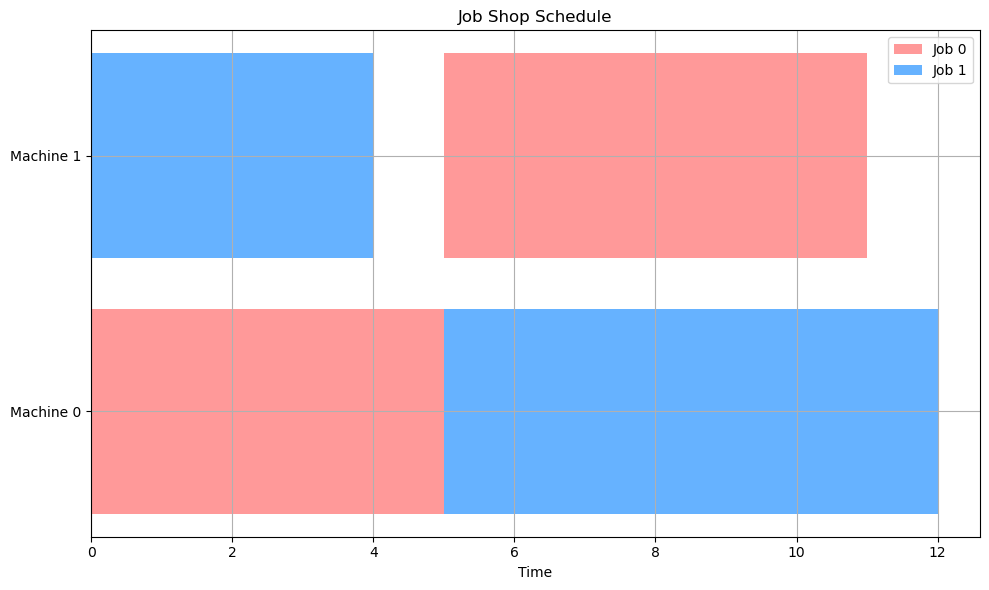

In [ ]:
import matplotlib.pyplot as plt

# Create Gantt chart
fig, ax = plt.subplots(figsize=(10, 6))

# Colors for each job
colors = ['#FF9999', '#66B2FF']

# For each machine
for m in range(2):
    # Plot Job 0 on this machine
    if m == 0:
        start = pulp.value(s0_0)
        duration = p0_m0
    else:
        start = pulp.value(s0_1)
        duration = p0_m1
    ax.barh(m, duration, left=start, color=colors[0], label='Job 0' if m==0 else "")

    # Plot Job 1 on this machine
    if m == 0:
        start = pulp.value(s1_0)
        duration = p1_m0
    else:
        start = pulp.value(s1_1)
        duration = p1_m1
    ax.barh(m, duration, left=start, color=colors[1], label='Job 1' if m==0 else "")

# Customize the chart
ax.set_yticks(range(2))
ax.set_yticklabels(['Machine 0', 'Machine 1'])
ax.set_xlabel('Time')
ax.set_title('Job Shop Schedule')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


# Excercise 1

Play with the code above to see how the schedule changes with different processing times.



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 22.4 MB/s eta 0:00:00
Status: Optimal
Objective (makespan) = 22.0
--- Start Times ---
s0_0 (Job0 on M0) = 0.0
s0_1 (Job0 on M1) = 10.0
s1_0 (Job1 on M0) = 10.0
s1_1 (Job1 on M1) = 0.0
--- Binary Orders ---
y0_01 (Machine 0 order) = 1.0
y1_01 (Machine 1 order) = 0.0


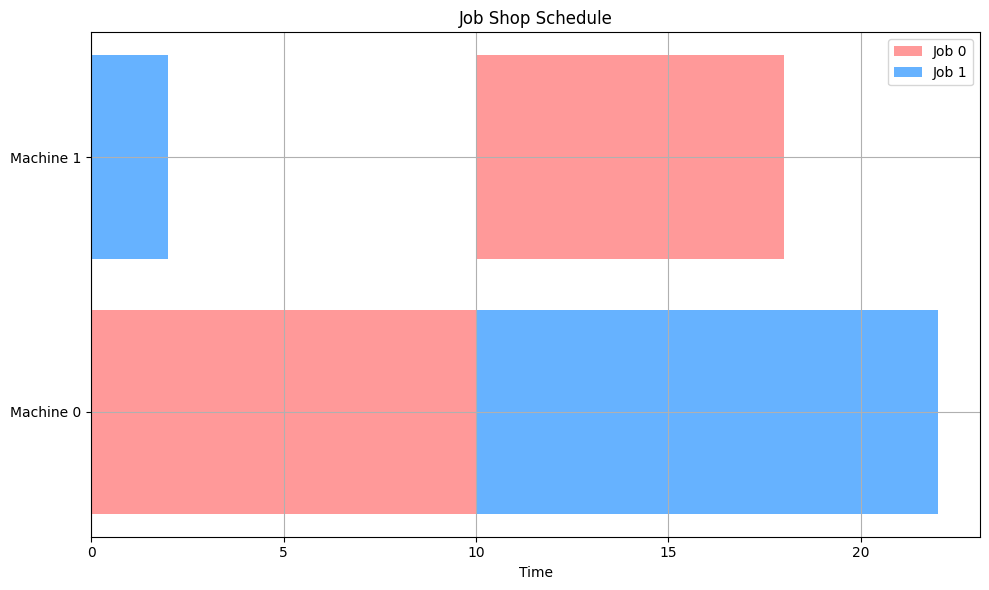

In [1]:
!pip install pulp

import pulp

# 1) Create the problem
model = pulp.LpProblem("Small_Job_Shop", pulp.LpMinimize)

# 2) Decision variables
# Start times:
# s0_0: Start time of Job 0 on Machine 0
# s0_1: Start time of Job 0 on Machine 1
# s1_0: Start time of Job 1 on Machine 0
# s1_1: Start time of Job 1 on Machine 1
s0_0 = pulp.LpVariable("s0_0", lowBound=0, cat='Continuous')
s0_1 = pulp.LpVariable("s0_1", lowBound=0, cat='Continuous')
s1_0 = pulp.LpVariable("s1_0", lowBound=0, cat='Continuous')
s1_1 = pulp.LpVariable("s1_1", lowBound=0, cat='Continuous')

# Makespan
Cmax = pulp.LpVariable("Cmax", lowBound=0, cat='Continuous')

# 3) Processing times
# Job 0: M0=5, then M1=6
p0_m0 = 10 # processing time of Job 0 on Machine 0
p0_m1 = 8 # processing time of Job 0 on Machine 1

# Job 1: M1=4, then M0=7
p1_m1 = 2 # processing time of Job 1 on Machine 1
p1_m0 = 12 # processing time of Job 1 on Machine 0

# 4) Binary variables for machine usage ordering
# We need these to ensure no overlap on each machine - each machine can process only one job at a time.
# For Machine 0, let y0_01 = 1 if Job 0 finishes before Job 1 starts on M0, else 0.
# For Machine 1, let y1_01 = 1 if Job 0 finishes before Job 1 starts on M1, else 0.
y0_01 = pulp.LpVariable("y0_01", cat='Binary')  # ordering on Machine 0
y1_01 = pulp.LpVariable("y1_01", cat='Binary')  # ordering on Machine 1

# Define a "big M" large enough to cover maximum possible scheduling time
bigM = 9999

# 5) OBJECTIVE: minimize Cmax
model += Cmax, "Minimize_the_makespan"

# 6) CONSTRAINTS

# -- (A) Operation sequence for each job --

# Job 0 must finish on Machine 0 before starting on Machine 1:
model += s0_1 >= s0_0 + p0_m0, "Seq_Job0" # start time of Job 0 on Machine 1 must be greater than or equal to the start time of Job 0 on Machine 0 plus the processing time of Job 0 on Machine 0

# Job 1 must finish on Machine 1 before starting on Machine 0:
model += s1_0 >= s1_1 + p1_m1, "Seq_Job1" # start time of Job 1 on Machine 0 must be greater than or equal to the start time of Job 1 on Machine 1 plus the processing time of Job 1 on Machine 1

# -- (B) No overlap on Machine 0 --
# Machine 0 is used by:
#   - Job 0 (from s0_0 to s0_0 + p0_m0)
#   - Job 1 (from s1_0 to s1_0 + p1_m0)
# Use a big-M approach with binary y0_01:

# If y0_01 = 1, Job0 finishes before Job1 starts on M0:
#     s1_0 >= s0_0 + p0_m0 - bigM*(1 - y0_01)
model += s1_0 >= s0_0 + p0_m0 - bigM*(1 - y0_01), "NoOverlap0a"

# If y0_01 = 0, Job1 finishes before Job0 starts on M0:
#     s0_0 >= s1_0 + p1_m0 - bigM*(y0_01)
model += s0_0 >= s1_0 + p1_m0 - bigM*(y0_01), "NoOverlap0b"

# -- (C) No overlap on Machine 1 --
# Machine 1 is used by:
#   - Job 0 (from s0_1 to s0_1 + p0_m1)
#   - Job 1 (from s1_1 to s1_1 + p1_m1)
# Use a big-M approach with y1_01:

# If y1_01 = 1, Job0 finishes before Job1 starts on M1:
#     s1_1 >= s0_1 + p0_m1 - bigM*(1 - y1_01)
model += s1_1 >= s0_1 + p0_m1 - bigM*(1 - y1_01), "NoOverlap1a"

# If y1_01 = 0, Job1 finishes before Job0 starts on M1:
#     s0_1 >= s1_1 + p1_m1 - bigM*(y1_01)
model += s0_1 >= s1_1 + p1_m1 - bigM*(y1_01), "NoOverlap1b"

# -- (D) Makespan definition --
# Finish time for Job 0 = time it completes on Machine 1 = s0_1 + p0_m1
# Finish time for Job 1 = time it completes on Machine 0 = s1_0 + p1_m0

model += Cmax >= s0_1 + p0_m1, "Makespan_Job0"
model += Cmax >= s1_0 + p1_m0, "Makespan_Job1"

# 7) Solve the model
model.solve(pulp.PULP_CBC_CMD(msg=False))

# 8) Print results
print("Status:", pulp.LpStatus[model.status])
print("Objective (makespan) =", pulp.value(model.objective))

# Decision variable values:
print("--- Start Times ---")
print("s0_0 (Job0 on M0) =", pulp.value(s0_0))
print("s0_1 (Job0 on M1) =", pulp.value(s0_1))
print("s1_0 (Job1 on M0) =", pulp.value(s1_0))
print("s1_1 (Job1 on M1) =", pulp.value(s1_1))

print("--- Binary Orders ---")
print("y0_01 (Machine 0 order) =", pulp.value(y0_01))
print("y1_01 (Machine 1 order) =", pulp.value(y1_01))

import matplotlib.pyplot as plt

# Create Gantt chart
fig, ax = plt.subplots(figsize=(10, 6))

# Colors for each job
colors = ['#FF9999', '#66B2FF']

# For each machine
for m in range(2):
    # Plot Job 0 on this machine
    if m == 0:
        start = pulp.value(s0_0)
        duration = p0_m0
    else:
        start = pulp.value(s0_1)
        duration = p0_m1
    ax.barh(m, duration, left=start, color=colors[0], label='Job 0' if m==0 else "")

    # Plot Job 1 on this machine
    if m == 0:
        start = pulp.value(s1_0)
        duration = p1_m0
    else:
        start = pulp.value(s1_1)
        duration = p1_m1
    ax.barh(m, duration, left=start, color=colors[1], label='Job 1' if m==0 else "")

# Customize the chart
ax.set_yticks(range(2))
ax.set_yticklabels(['Machine 0', 'Machine 1'])
ax.set_xlabel('Time')
ax.set_title('Job Shop Schedule')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


#More general job shop problem example

## Data Setup
Let's define for each job:
- The machine sequence the job must follow
- The processing time on each machine (in hours)

### Job Specifications:

**Job 0:**
- Machine sequence: Machine 0 → Machine 1 → Machine 2
- Processing times: 5, 6, 4 hours respectively

**Job 1:**
- Machine sequence: Machine 1 → Machine 2 → Machine 0  
- Processing times: 4, 3, 7 hours respectively

**Job 2:**
- Machine sequence: Machine 0 → Machine 2 → Machine 1
- Processing times: 6, 4, 5 hours respectively

We will store this data in two parallel 2D lists:
- `machine_order`: Contains the sequence of machines for each job
- `processing_time`: Contains the corresponding processing times



In [ ]:
#!pip install pulp

import pulp

# -------------------------
# 1) PROBLEM PARAMETERS
# -------------------------
num_jobs = 3
num_machines = 3

# machine_order[job] = list of machines in the order they must be processed
# Example: Job 0 -> Machine 0 -> Machine 1 -> Machine 2
machine_order = [
    [0, 1, 2],  # Job 0
    [1, 2, 0],  # Job 1
    [0, 2, 1]   # Job 2
]

# processing_time[job] = list of processing times for each operation in the sequence
# For Job 0: 5 hours on Machine 0, 6 hours on Machine 1, 4 hours on Machine 2
processing_time = [
    [5, 6, 4],  # Job 0
    [4, 3, 7],  # Job 1
    [6, 4, 5]   # Job 2
]

# -------------------------
# 2) DECISION VARIABLES
# -------------------------
# We'll create a variable start_time[m, j] = the start time of Job j on Machine m.
# Because each job visits each machine exactly once (in a known order), we can define variables for each (m, j).
# Alternatively, we might define them only in operation order; for simplicity, we'll define them for (m, j).
start_time = pulp.LpVariable.dicts(
    "start_time",
    [(m, j) for m in range(num_machines) for j in range(num_jobs)],
    lowBound=0,
    cat='Continuous'
)

# We'll create a variable Cmax to represent the makespan (the maximum finishing time).
Cmax = pulp.LpVariable('Cmax', lowBound=0, cat='Continuous')

# -------------------------
# 3) MODEL
# -------------------------
model = pulp.LpProblem("Job_Shop_Scheduling", pulp.LpMinimize)

# Objective: Minimize the makespan
model += Cmax, "Minimize_makespan"

# -------------------------
# 4) CONSTRAINTS
# -------------------------

# (A) **Operation sequence** constraints:
#     For each job j, each operation must start after the previous one finishes.

for j in range(num_jobs):
    for op in range(num_machines - 1):
        current_machine = machine_order[j][op]
        next_machine = machine_order[j][op + 1]

        current_op_time = processing_time[j][op]

        # The start of the next operation must be >= (start of current operation + processing time).
        model += start_time[next_machine, j] >= (
            start_time[current_machine, j] + current_op_time
        ), f"SequenceConstraint_Job{j}_Op{op}"

# (B) **No overlap on the same machine**:
#     If two jobs j1 and j2 require the same machine m, only one can run at a time.
#     We'll use the "big-M" approach with binary variables to enforce non-overlapping intervals.

# Big M can be a large enough number. For a small example, let's pick something > sum of all times.
bigM = 9999

# Create binary variables that indicate ordering between job pairs on each machine.
# y[m, j1, j2] = 1 means job j1 finishes before job j2 starts (on machine m).
y = pulp.LpVariable.dicts(
    "y",
    [(m, j1, j2) for m in range(num_machines) for j1 in range(num_jobs) for j2 in range(num_jobs) if j1 != j2],
    cat='Binary'
)

for m in range(num_machines):
    # Retrieve jobs that run on machine m, but we actually know each job runs on m exactly once in some order
    # We just loop over all pairs j1, j2.
    for j1 in range(num_jobs):
        for j2 in range(num_jobs):
            if j1 != j2:
                # processing time of job j1 on machine m
                # We need to figure out which operation index job j1 uses machine m
                op_j1 = machine_order[j1].index(m)  # index of machine m in job j1's sequence
                proc_j1 = processing_time[j1][op_j1]

                op_j2 = machine_order[j2].index(m)
                proc_j2 = processing_time[j2][op_j2]

                # Non-overlap constraints:
                # start_time[m, j2] >= start_time[m, j1] + proc_j1 - bigM*(1 - y[m, j1, j2])
                model += start_time[m, j2] >= start_time[m, j1] + proc_j1 - bigM * (1 - y[m, j1, j2])

                # Similarly:
                # start_time[m, j1] >= start_time[m, j2] + proc_j2 - bigM*(y[m, j1, j2])
                model += start_time[m, j1] >= start_time[m, j2] + proc_j2 - bigM * (y[m, j1, j2])

# (C) **Makespan definition**:
#     For each job j, the finishing time on its last machine must be <= Cmax.
for j in range(num_jobs):
    # last machine index for job j (the job visits machines in a known order)
    last_machine = machine_order[j][-1]
    # last operation index (which is num_machines - 1)
    last_op_idx = num_machines - 1
    finish_time_j = start_time[last_machine, j] + processing_time[j][last_op_idx]

    model += Cmax >= finish_time_j, f"CmaxConstraint_Job{j}"

# -------------------------
# 5) SOLVE
# -------------------------
model.solve(pulp.PULP_CBC_CMD(msg=False))

print("Solution Status:", pulp.LpStatus[model.status])
print("Objective (makespan) =", pulp.value(model.objective))

# Print the start times
for (m, j) in start_time:
    print(f"Start time of Job {j} on Machine {m} = {pulp.value(start_time[m, j])}")


Solution Status: Optimal
Objective (makespan) = 20.0
Start time of Job 0 on Machine 0 = 0.0
Start time of Job 1 on Machine 0 = 11.0
Start time of Job 2 on Machine 0 = 5.0
Start time of Job 0 on Machine 1 = 5.0
Start time of Job 1 on Machine 1 = 0.0
Start time of Job 2 on Machine 1 = 15.0
Start time of Job 0 on Machine 2 = 15.0
Start time of Job 1 on Machine 2 = 4.0
Start time of Job 2 on Machine 2 = 11.0


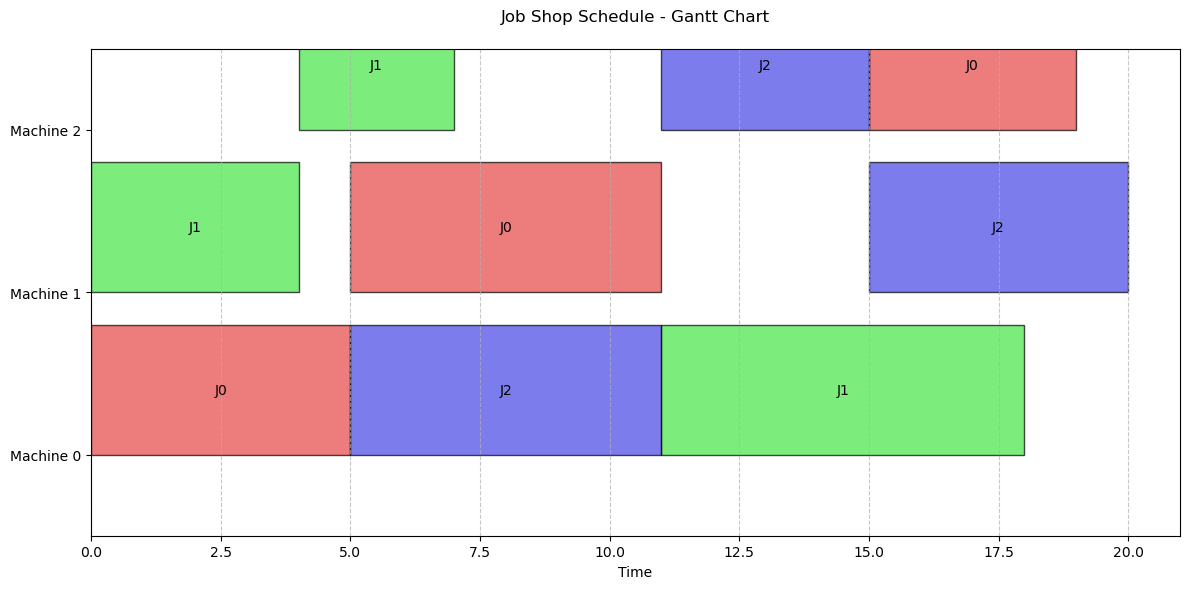

In [ ]:
# Create Gantt chart
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import colorsys

# Set up the plot with dynamic sizing based on number of machines
fig_height = max(6, num_machines * 0.5)  # Increase height for many machines
fig, ax = plt.subplots(figsize=(12, fig_height))

# Generate colors dynamically based on number of jobs
def generate_colors(n):
    colors = []
    for i in range(n):
        hue = i / n
        saturation = 0.7
        value = 0.9
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        colors.append(rgb)
    return colors

colors = generate_colors(num_jobs)

# For each machine and job
for m in range(num_machines):
    for j in range(num_jobs):
        # Get start time and processing time
        start = pulp.value(start_time[m, j])
        op_idx = machine_order[j].index(m)
        duration = processing_time[j][op_idx]

        # Calculate rectangle height based on number of machines
        rect_height = min(0.8, 0.95 - (0.01 * num_machines))

        # Create rectangle for this operation
        rect = patches.Rectangle(
            (start, m),                     # (x,y)
            duration,                       # width
            rect_height,                    # height
            facecolor=colors[j],
            edgecolor='black',
            alpha=0.7
        )

        # Add rectangle to plot
        ax.add_patch(rect)

        # Adjust text size based on number of jobs and machines
        text_size = max(8, min(10, 200/(num_jobs * num_machines)))

        # Add job number text in the middle of rectangle
        ax.text(start + duration/2, m + rect_height/2, f'J{j}',
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=text_size)

# Customize the plot
ax.set_ylim(-0.5, num_machines - 0.5)
ax.set_xlim(0, pulp.value(Cmax) * 1.05)  # Add 5% margin

# Adjust tick label size based on number of machines
tick_size = max(8, min(10, 120/num_machines))
ax.set_yticks(range(num_machines))
ax.set_yticklabels([f'Machine {m}' for m in range(num_machines)], fontsize=tick_size)
ax.set_xlabel('Time', fontsize=tick_size)
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

plt.title('Job Shop Schedule - Gantt Chart', pad=20, fontsize=tick_size + 2)
plt.tight_layout()
plt.show()


# Excercise 1b:
Play with the code above, see how the Cmax changes with different processing times, different variations of the problem.
# Excercise 2

Add a machine to the problem. Use %%timeit to see how the solver performance changes.

Execution time: 0.0415 seconds


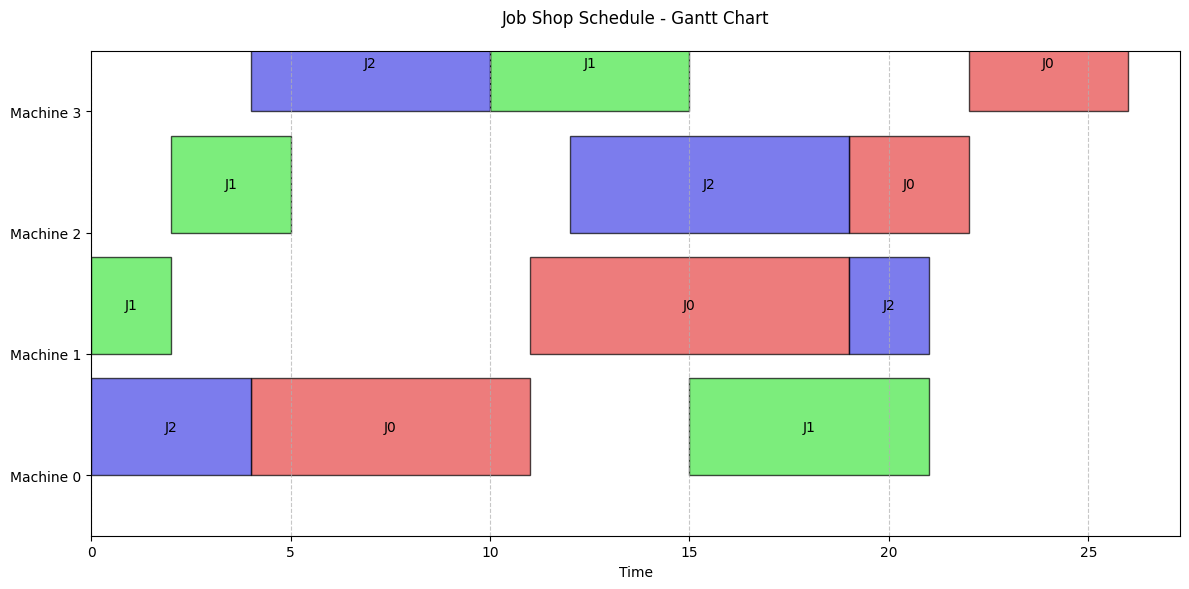

In [8]:
!pip install pulp

import pulp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import colorsys
import timeit

def solve_job_shop():
    num_jobs = 3
    num_machines = 4

    machine_order = [
        [0, 1, 2, 3],
        [1, 2, 3, 0],
        [0, 3, 2, 1]
    ]

    processing_time = [
        [7, 8, 3, 4],
        [2, 3, 5, 6],
        [4, 6, 7, 2]
    ]

    start_time = pulp.LpVariable.dicts(
        "start_time",
        [(m, j) for m in range(num_machines) for j in range(num_jobs)],
        lowBound=0,
        cat='Continuous'
    )
    Cmax = pulp.LpVariable('Cmax', lowBound=0, cat='Continuous')

    model = pulp.LpProblem("Job_Shop_Scheduling", pulp.LpMinimize)
    model += Cmax, "Minimize_makespan"

    for j in range(num_jobs):
        for op in range(num_machines - 1):
            current_machine = machine_order[j][op]
            next_machine = machine_order[j][op + 1]
            current_op_time = processing_time[j][op]
            model += start_time[next_machine, j] >= (
                start_time[current_machine, j] + current_op_time
            )

    bigM = 9999
    y = pulp.LpVariable.dicts(
        "y",
        [(m, j1, j2) for m in range(num_machines)
         for j1 in range(num_jobs) for j2 in range(num_jobs) if j1 != j2],
        cat='Binary'
    )

    for m in range(num_machines):
        for j1 in range(num_jobs):
            for j2 in range(num_jobs):
                if j1 != j2:
                    op_j1 = machine_order[j1].index(m)
                    op_j2 = machine_order[j2].index(m)
                    proc_j1 = processing_time[j1][op_j1]
                    proc_j2 = processing_time[j2][op_j2]

                    model += start_time[m, j2] >= start_time[m, j1] + proc_j1 - bigM * (1 - y[m, j1, j2])
                    model += start_time[m, j1] >= start_time[m, j2] + proc_j2 - bigM * y[m, j1, j2]

    for j in range(num_jobs):
        last_machine = machine_order[j][-1]
        finish_time_j = start_time[last_machine, j] + processing_time[j][-1]
        model += Cmax >= finish_time_j

    model.solve(pulp.PULP_CBC_CMD(msg=False))

    return pulp.value(model.objective), start_time, Cmax, num_jobs, num_machines, machine_order, processing_time

# Run and measure time
execution_time = timeit.timeit(solve_job_shop, number=1)
print(f"Execution time: {execution_time:.4f} seconds")

# Retrieve and unpack results for Gantt chart
_, start_time, Cmax, num_jobs, num_machines, machine_order, processing_time = solve_job_shop()

# Gantt Chart
fig_height = max(6, num_machines * 0.5)
fig, ax = plt.subplots(figsize=(12, fig_height))

def generate_colors(n):
    colors = []
    for i in range(n):
        hue = i / n
        saturation = 0.7
        value = 0.9
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        colors.append(rgb)
    return colors

colors = generate_colors(num_jobs)

for m in range(num_machines):
    for j in range(num_jobs):
        start = pulp.value(start_time[m, j])
        op_idx = machine_order[j].index(m)
        duration = processing_time[j][op_idx]
        rect_height = min(0.8, 0.95 - (0.01 * num_machines))

        rect = patches.Rectangle(
            (start, m),
            duration,
            rect_height,
            facecolor=colors[j],
            edgecolor='black',
            alpha=0.7
        )
        ax.add_patch(rect)

        text_size = max(8, min(10, 200/(num_jobs * num_machines)))
        ax.text(start + duration/2, m + rect_height/2, f'J{j}',
                ha='center', va='center', fontsize=text_size)

ax.set_ylim(-0.5, num_machines - 0.5)
ax.set_xlim(0, pulp.value(Cmax) * 1.05)
tick_size = max(8, min(10, 120/num_machines))
ax.set_yticks(range(num_machines))
ax.set_yticklabels([f'Machine {m}' for m in range(num_machines)], fontsize=tick_size)
ax.set_xlabel('Time', fontsize=tick_size)
ax.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.title('Job Shop Schedule - Gantt Chart', pad=20, fontsize=tick_size + 2)
plt.tight_layout()
plt.show()


# Excercise 3:

Make the problem interactive, add a way to specify the number of jobs and machines interactively

Enter the number of jobs: 2
Enter the number of machines: 3

For each job, specify the order of machines and the processing times.

Job 0:
  Enter the machine order (space-separated 3 values): 0 1 2
  Enter the processing times (space-separated 3 values): 5 3 6

Job 1:
  Enter the machine order (space-separated 3 values): 1 2 0
  Enter the processing times (space-separated 3 values): 4 2 7

Solving time: 0.0108 seconds
Makespan: 14.0


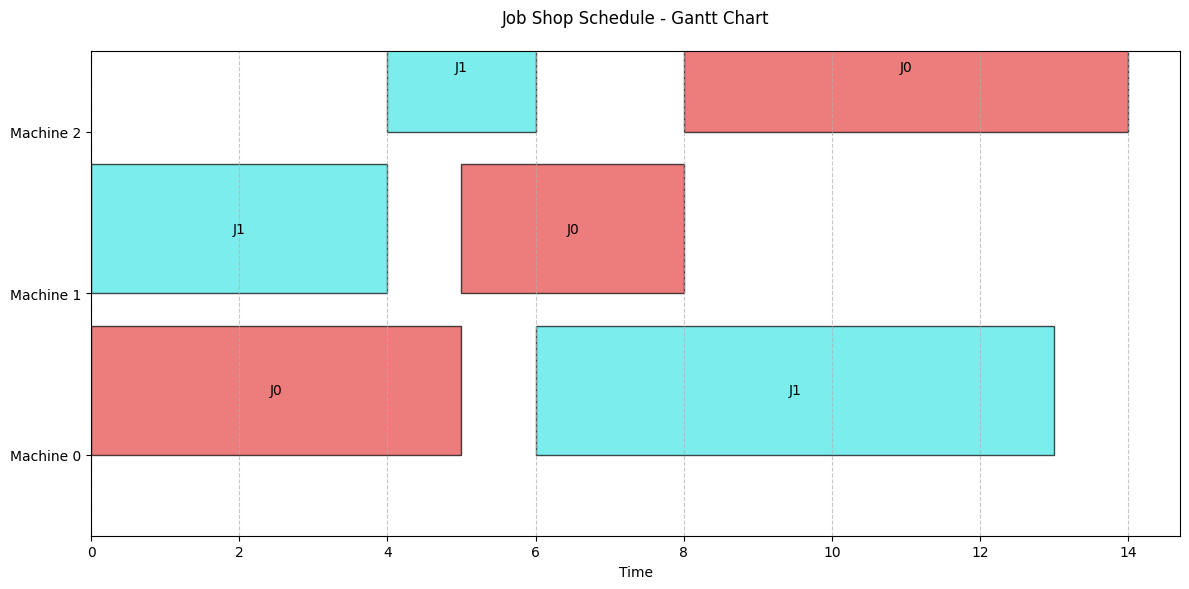

In [9]:
!pip install pulp

import pulp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import colorsys
import timeit

# Step 1: Get input from the user
def get_user_input():
    num_jobs = int(input("Enter the number of jobs: "))
    num_machines = int(input("Enter the number of machines: "))

    machine_order = []
    processing_time = []

    print("\nFor each job, specify the order of machines and the processing times.")
    for j in range(num_jobs):
        print(f"\nJob {j}:")
        order = list(map(int, input(f"  Enter the machine order (space-separated {num_machines} values): ").split()))
        times = list(map(int, input(f"  Enter the processing times (space-separated {num_machines} values): ").split()))

        if len(order) != num_machines or len(times) != num_machines:
            raise ValueError("Invalid input length. Must match number of machines.")

        machine_order.append(order)
        processing_time.append(times)

    return num_jobs, num_machines, machine_order, processing_time

# Step 2: Solve job shop problem
def solve_job_shop(num_jobs, num_machines, machine_order, processing_time):
    start_time = pulp.LpVariable.dicts(
        "start_time",
        [(m, j) for m in range(num_machines) for j in range(num_jobs)],
        lowBound=0,
        cat='Continuous'
    )
    Cmax = pulp.LpVariable('Cmax', lowBound=0, cat='Continuous')

    model = pulp.LpProblem("Job_Shop_Scheduling", pulp.LpMinimize)
    model += Cmax, "Minimize_makespan"

    for j in range(num_jobs):
        for op in range(num_machines - 1):
            current_machine = machine_order[j][op]
            next_machine = machine_order[j][op + 1]
            current_op_time = processing_time[j][op]
            model += start_time[next_machine, j] >= start_time[current_machine, j] + current_op_time

    bigM = 9999
    y = pulp.LpVariable.dicts(
        "y",
        [(m, j1, j2) for m in range(num_machines)
         for j1 in range(num_jobs) for j2 in range(num_jobs) if j1 != j2],
        cat='Binary'
    )

    for m in range(num_machines):
        for j1 in range(num_jobs):
            for j2 in range(num_jobs):
                if j1 != j2:
                    try:
                        op_j1 = machine_order[j1].index(m)
                        op_j2 = machine_order[j2].index(m)
                        proc_j1 = processing_time[j1][op_j1]
                        proc_j2 = processing_time[j2][op_j2]

                        model += start_time[m, j2] >= start_time[m, j1] + proc_j1 - bigM * (1 - y[m, j1, j2])
                        model += start_time[m, j1] >= start_time[m, j2] + proc_j2 - bigM * y[m, j1, j2]
                    except ValueError:
                        continue  # One of the jobs doesn't use this machine

    for j in range(num_jobs):
        last_machine = machine_order[j][-1]
        finish_time_j = start_time[last_machine, j] + processing_time[j][-1]
        model += Cmax >= finish_time_j

    model.solve(pulp.PULP_CBC_CMD(msg=False))

    return pulp.value(model.objective), start_time, Cmax

# Step 3: Draw Gantt chart
def draw_gantt_chart(start_time, Cmax, num_jobs, num_machines, machine_order, processing_time):
    fig_height = max(6, num_machines * 0.5)
    fig, ax = plt.subplots(figsize=(12, fig_height))

    def generate_colors(n):
        return [colorsys.hsv_to_rgb(i/n, 0.7, 0.9) for i in range(n)]

    colors = generate_colors(num_jobs)

    for m in range(num_machines):
        for j in range(num_jobs):
            if m not in machine_order[j]:
                continue  # skip if job j doesn't use machine m

            start = pulp.value(start_time[m, j])
            op_idx = machine_order[j].index(m)
            duration = processing_time[j][op_idx]
            rect_height = min(0.8, 0.95 - (0.01 * num_machines))

            rect = patches.Rectangle(
                (start, m), duration, rect_height,
                facecolor=colors[j], edgecolor='black', alpha=0.7
            )
            ax.add_patch(rect)

            text_size = max(8, min(10, 200/(num_jobs * num_machines)))
            ax.text(start + duration/2, m + rect_height/2, f'J{j}', ha='center', va='center', fontsize=text_size)

    ax.set_ylim(-0.5, num_machines - 0.5)
    ax.set_xlim(0, pulp.value(Cmax) * 1.05)
    ax.set_yticks(range(num_machines))
    ax.set_yticklabels([f'Machine {m}' for m in range(num_machines)], fontsize=10)
    ax.set_xlabel('Time')
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.title('Job Shop Schedule - Gantt Chart', pad=20)
    plt.tight_layout()
    plt.show()

# Step 4: Main program flow
if __name__ == "__main__":
    num_jobs, num_machines, machine_order, processing_time = get_user_input()
    execution_time = timeit.timeit(lambda: solve_job_shop(num_jobs, num_machines, machine_order, processing_time), number=1)
    print(f"\nSolving time: {execution_time:.4f} seconds")

    makespan, start_time, Cmax = solve_job_shop(num_jobs, num_machines, machine_order, processing_time)
    print(f"Makespan: {makespan}")

    draw_gantt_chart(start_time, Cmax, num_jobs, num_machines, machine_order, processing_time)


The problem can be very hard for a larger number of jobs and machines. There are some heuristics that can be used to solve it. Some interesting methods are:
- Genetic algorithms
- Simulated annealing
- Tabu search
- Ant colony optimization
- Particle swarm optimization
